In [1]:
from sql import *
from stats import *
import pandas as pd
from lifelines import *

In [23]:
from matplotlib import pyplot
%matplotlib notebook

from matplotlib import pyplot
%matplotlib notebook

In [21]:
fragdata = split_data(download_frag_data())
mainzones = ['Water Villas (LG)', 'Channel (KH)', 'Blue Holes (LG)', 'Parrot Reef (LG)', 'Water Villas (KH)', 'House Reef (KH)', 
         'Blu (LG)', 'Blu Deep (LG)', 'Dive Site (LG)', 'Coral Trail (LG)', 'Anchor Point (LG)', 'Al Barakat (LG)']
controlzones = ['Blu (LG)', 'Blu Deep (LG)', 'Dive Site (LG)', 'Coral Trail (LG)', 'Anchor Point (LG)', 'Al Barakat (LG)']
disruptedzones = ['Water Villas (LG)', 'Channel (KH)', 'Blue Holes (LG)', 'Parrot Reef (LG)', 'Water Villas (KH)', 'House Reef (KH)']

main = fragdata['all'][fragdata['all']['Zone'].isin(mainzones)]
control = fragdata['all'][fragdata['all']['Zone'].isin(controlzones)]
disrupted = fragdata['all'][fragdata['all']['Zone'].isin(disruptedzones)]

# Mortality

In [11]:
survived, dead = get_mortality()

<IPython.core.display.Javascript object>


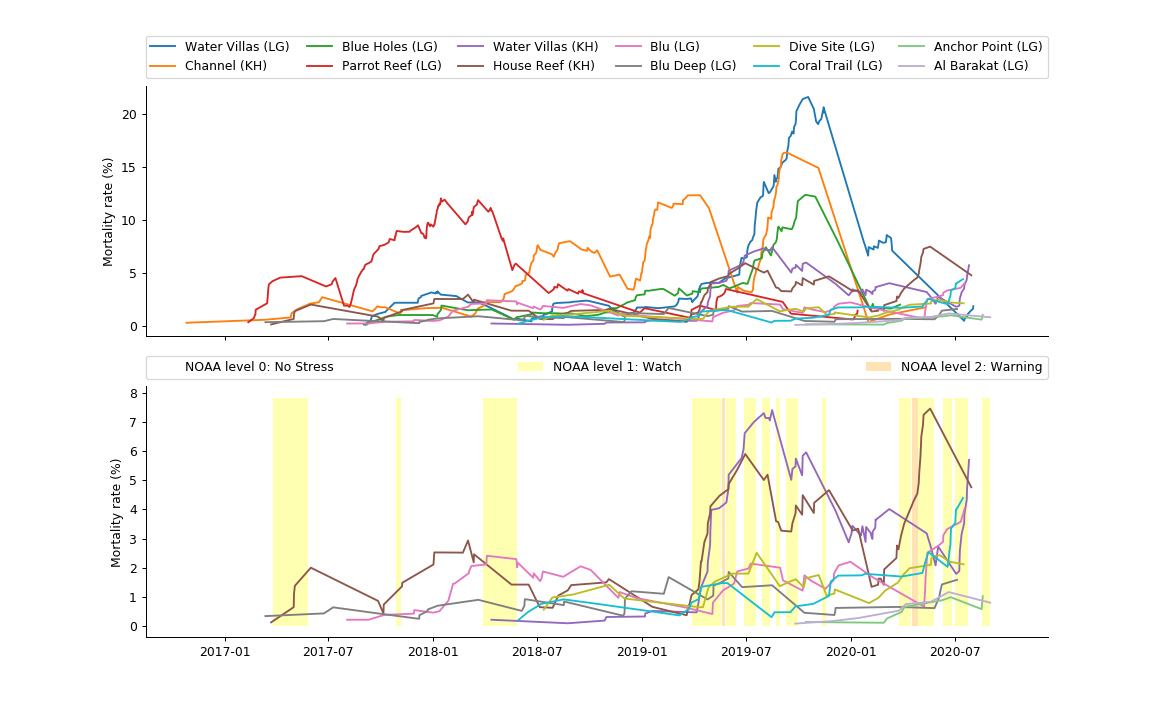

In [23]:
roll_window = 120
fig, axs = pyplot.subplots(2, sharex = True, figsize = [13,8])
mortality = {}
lines = {}
colors = [pyplot.cm.tab10(x) for x in np.linspace(0,1,10)] + [pyplot.cm.Accent(x) for x in np.linspace(0,1,8)]
axs[0].set_prop_cycle('color', colors)

for z in mainzones:
    zone_survived = survived[survived['Zone'] == z]
    zone_dead = dead[dead['Zone'] == z]
    mortality[z] = zone_dead['Median'].value_counts() / (zone_dead['Median'].value_counts() + zone_survived['Median'].value_counts())
    mortality[z] = mortality[z].sort_index().rolling(str(roll_window) + 'd').sum().rename(z) / roll_window * 100
    lines[z], = axs[0].plot_date(mortality[z].index, mortality[z], '-')

for z in mainzones[4:]:
    zone_survived = survived[survived['Zone'] == z]
    zone_dead = dead[dead['Zone'] == z]
    mortality[z] = zone_dead['Median'].value_counts() / (zone_dead['Median'].value_counts() + zone_survived['Median'].value_counts())
    mortality[z] = mortality[z].sort_index().rolling(str(roll_window) + 'd').sum().rename(z) / roll_window * 100
    axs[1].plot_date(mortality[z].index, mortality[z], '-', color = lines[z].get_color(), label = '_' + z)

colors = pd.read_csv('kh_temp_alert.csv', index_col = 0, parse_dates = True)
d = colors.index
lim = axs[1].get_ylim()[1]
axs[1].fill_between(d, 0, lim, where=colors['level'] == 0, facecolor='yellow', alpha=0, label = 'NOAA level 0: No Stress')
axs[1].fill_between(d, 0, lim, where=colors['level'] == 1, facecolor='yellow', alpha=0.3, label = 'NOAA level 1: Watch')
axs[1].fill_between(d, 0, lim, where=colors['level'] == 2, facecolor='orange', alpha=0.3, label = 'NOAA level 2: Warning')
axs[1].fill_between(d, 0, lim, where=colors['level'] == 3, facecolor='red', alpha=0.3)
axs[1].fill_between(d, 0, lim, where=colors['level'] == 4, facecolor='darkred', alpha=0.3)

axs[0].legend(loc='lower left', ncol=6, bbox_to_anchor=(0., 1.03, 1., .102), mode="expand", borderaxespad=0.)
axs[1].legend(loc='lower left', ncol=6, bbox_to_anchor=(0., 1.03, 1., .102), mode="expand", borderaxespad=0.)
axs[0].set(ylabel='Mortality rate (%)')
axs[1].set(ylabel='Mortality rate (%)')
axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)
axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)

# Global survival results

<IPython.core.display.Javascript object>


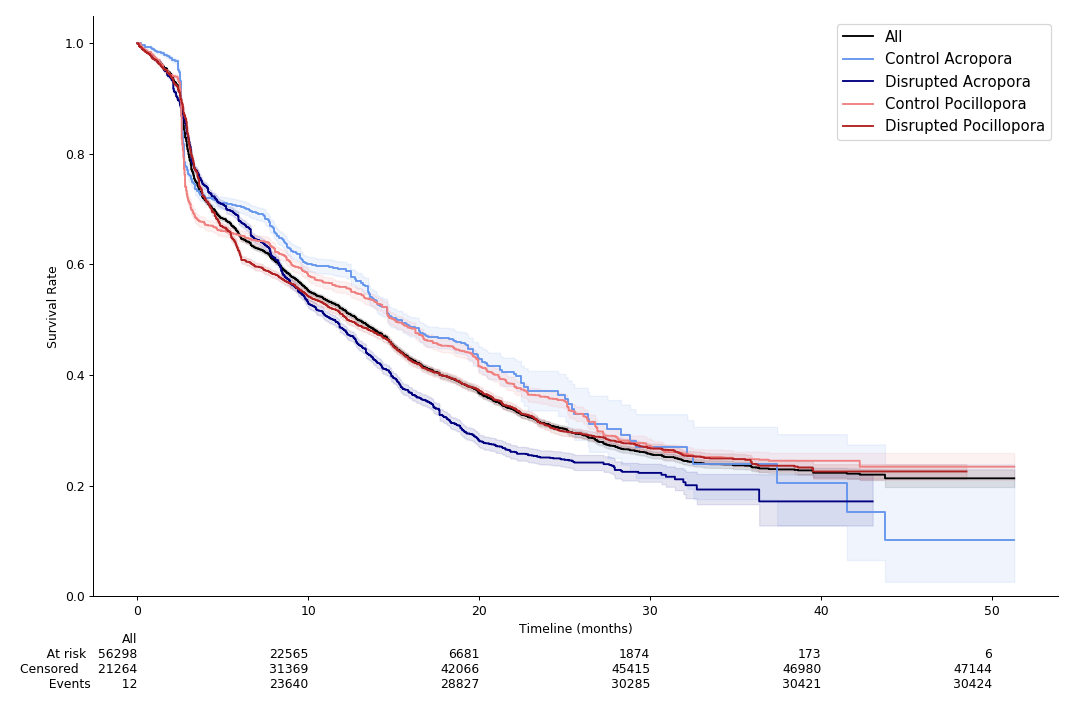

In [26]:
fig, ax = pyplot.subplots(figsize=[12, 8])

df0 = fragdata['all']
df1 = control[control['Type'] == 'Acropora']
df2 = control[control['Type'] == 'Pocillopora']
df3 = disrupted[disrupted['Type'] == 'Acropora']
df4 = disrupted[disrupted['Type'] == 'Pocillopora']

kmf0 = KaplanMeierFitter()
kmf0.fit(df0['T'] / 30.437, event_observed=df0['E'], label = 'All')
kmf1 = KaplanMeierFitter()
kmf1.fit(df1['T'] / 30.437, event_observed=df1['E'], label = 'Control Acropora')
kmf2 = KaplanMeierFitter()
kmf2.fit(df2['T'] / 30.437, event_observed=df2['E'], label = 'Control Pocillopora')
kmf3 = KaplanMeierFitter()
kmf3.fit(df3['T'] / 30.437, event_observed=df3['E'], label = 'Disrupted Acropora')
kmf4 = KaplanMeierFitter()
kmf4.fit(df4['T'] / 30.437, event_observed=df4['E'], label = 'Disrupted Pocillopora')

kmf0.plot_survival_function(ax=ax, color = 'black', ci_alpha = 0.1)
kmf1.plot_survival_function(ax=ax, color = 'cornflowerblue', ci_alpha = 0.1)
kmf3.plot_survival_function(ax=ax, color = 'navy', ci_alpha = 0.1)
kmf2.plot_survival_function(ax=ax, color = 'lightcoral', ci_alpha = 0.1)
kmf4.plot_survival_function(ax=ax, color = 'firebrick', ci_alpha = 0.1)

from lifelines.plotting import add_at_risk_counts
add_at_risk_counts(kmf0, ax=ax)

ax.set_ylim(bottom=0)
ax.set_xlabel('Timeline (months)')
ax.set_ylabel('Survival Rate')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(prop={'size': 12})


# Causes of death

In [30]:
request = """SELECT Fragments.Type AS Sp, Status.Type, COUNT(Status.FragmentId) FROM (
        SELECT FragmentId, MIN(Date) AS death FROM Status WHERE Type IN ('Dead Coral', 'Fallen') GROUP BY FragmentId
        ) A INNER JOIN Status ON A.FragmentId = Status.FragmentId AND A.death = Status.Date
        INNER JOIN Fragments ON Fragments.FragmentId = A.FragmentID
        INNER JOIN FSFrames ON Fragments.Tag = FSFrames.Tag
        WHERE Fragments.Type IN ('Acropora', 'Pocillopora')
        AND Zone IN ('Blu (LG)', 'Blu Deep (LG)', 'Dive Site (LG)', 'Coral Trail (LG)', 'Anchor Point (LG)', 'Al Barakat (LG)')
        GROUP BY Sp, Type"""

db = OpenMydb(database = "thomas17_AI")
cur = db.cursor()
cur.execute(request)
for c in cur.fetchall():
    print('{}, {}: {}'.format(c[0], c[1], c[2]))

Acropora, Dead Coral: 462
Acropora, Fallen: 2180
Pocillopora, Dead Coral: 428
Pocillopora, Fallen: 4788


# Cox Regression (control)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


<lifelines.CoxPHFitter: fitted with 9759 total observations, 5146 right-censored observations>
             duration col = 'T'
                event col = 'E'
          robust variance = True
      baseline estimation = breslow
   number of observations = 9759
number of events observed = 4613
   partial log-likelihood = -38868.64
         time fit was run = 2020-11-26 08:35:34 UTC

---
                                       coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                    
C(Type)[T.Pocillopora]                -0.87       0.42       0.11            -1.09            -0.65                 0.34                 0.52
np.log(Depth)                         -0.27       0.76       0.03            -0.32            -0.22                 0.72                 0.80
C(Type)[T.Pocillopora]:np.log(Depth)   0.27       1.31       0.03             0.20             0.34                 1.22                 1.40
Size                                   0.06       1.06       0.02             0.02             0.09                 1.02                 1.10
C(Type)[T.Pocillopora]:Size            0.05       1.05       0.02             0.01             0.09                 1.01                 1.09
Sandy:Bottom                           0.25       1.28       0.03             0.19             0.31                 1.20                 1.36

                                          z      p   -log2(p)
covariate                                                    
C(Type)[T.Pocillopora]                -7.88 <0.005      48.15
np.log(Depth)                        -10.34 <0.005      80.78
C(Type)[T.Pocillopora]:np.log(Depth)   7.73 <0.005      46.45
Size                                   3.08 <0.005       8.91
C(Type)[T.Pocillopora]:Size            2.32   0.02       5.62
Sandy:Bottom                           7.94 <0.005      48.85
---
Concordance = 0.57
Partial AIC = 77749.27
log-likelihood ratio test = 314.34 on 6 df
-log2(p) of ll-ratio test = 213.14

<IPython.core.display.Javascript object>


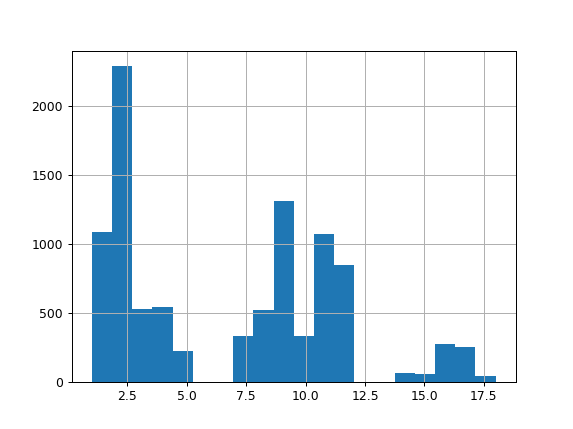

In [24]:
df = control.copy()
df['Size'] = 0.3296*df['Size']
df['tdelta'] = (df['Transplanted'] - df['StartDate']).dt.days <= 90
df = df[df['tdelta']]

X = df[['T', 'E', 'Size', 'Depth', 'Type']]
X['Bottom'] = 1*(df['Elev'] == 'A')
X['Sandy'] =1*df['Sandy']

cph = CoxPHFitter()
cph.fit(X, duration_col='T', event_col='E', formula="C(Type)*np.log(Depth)+C(Type)*Size+Sandy:Bottom", robust=True)

cph.print_summary()
X['Depth'].hist(bins = 20)

<IPython.core.display.Javascript object>


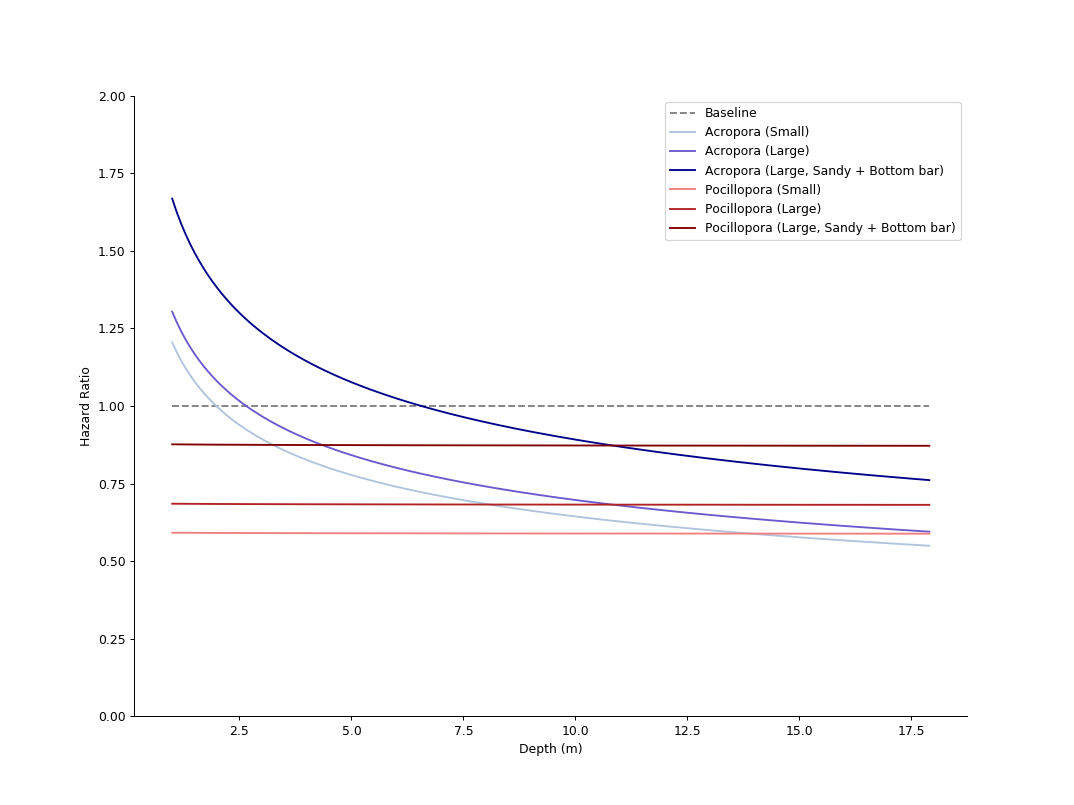

In [30]:
p_, d_, pd_, s_, ps_, sb_ = cph.params_
a_ = -p_
d = np.arange(1, 18, 0.1)
s1, s3 = 3.3, 4.7
fig, ax = pyplot.subplots(figsize = [12,9])

ax.plot(d, pd.Series(1, index = d), '--', label = 'Baseline', color = 'gray')
ax.plot(d, d**(d_)*np.exp(s1*(s_))*np.exp(sb_*0), label = 'Acropora (Small)', color = 'lightsteelblue')
ax.plot(d, d**(d_)*np.exp(s3*(s_))*np.exp(sb_*0), label = 'Acropora (Large)', color = 'slateblue')
ax.plot(d, d**(d_)*np.exp(s3*(s_))*np.exp(sb_*1), label = 'Acropora (Large, Sandy + Bottom bar)', color = 'darkblue')
ax.plot(d, np.exp(p_)*d**(d_+pd_)*np.exp(s1*(s_+ps_))*np.exp(sb_*0), label = 'Pocillopora (Small)', color = 'lightcoral')
ax.plot(d, np.exp(p_)*d**(d_+pd_)*np.exp(s3*(s_+ps_))*np.exp(sb_*0), label = 'Pocillopora (Large)', color = 'firebrick')
ax.plot(d, np.exp(p_)*d**(d_+pd_)*np.exp(s3*(s_+ps_))*np.exp(sb_*1), label = 'Pocillopora (Large, Sandy + Bottom bar)', color = 'maroon')
ax.legend()
ax.set_ylim(0, 2)
ax.set(xlabel='Depth (m)', ylabel='Hazard Ratio')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Cox Regression (disrupted)

In [3]:
long_df = get_disrupted_frag_data('heatwave')

/home/mdc/Desktop/Statistics/stats.py:172: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Size'] = 0.3296*df['Size']
/home/mdc/Desktop/Statistics/stats.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tdelta'] = (df['Transplanted'] - df['StartDate']).dt.days <= 90
/usr/local/lib/python3.6/dist-packages/pandas/core/arrays/datetimelike.py:1268: PerformanceWarning: Adding/subtracting array of DateOffsets to TimedeltaArray not vectorized
  PerformanceWarning,


In [28]:
X = long_df[['FragmentId', 'Type', 'Size']].copy()
X['Start'], X['Stop']  = long_df['Start'].astype(int), long_df['Stop'].astype(int)
X['E'], X['Disrupted'] = long_df['E'].astype(int), long_df['Disrupted'].astype(int)

from lifelines import CoxTimeVaryingFitter

ctv = CoxTimeVaryingFitter(penalizer=0.0001)
ctv.fit(X, id_col="FragmentId", event_col="E", start_col="Start", stop_col="Stop", formula='C(Type)*Disrupted+C(Type):Size')
ctv.print_summary()
X.info()

<lifelines.CoxTimeVaryingFitter: fitted with 14926 periods, 8262 subjects, 4297 events>
         event col = 'E'
         penalizer = 0.0001
number of subjects = 8262
 number of periods = 14926
  number of events = 4297
partial log-likelihood = -35581.24
  time fit was run = 2020-11-26 10:09:08 UTC

---
                                   coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                
C(Type)[T.Pocillopora]             0.55       1.74       0.15             0.27             0.84                 1.30                 2.31
Disrupted                          1.10       3.00       0.04             1.03             1.17                 2.80                 3.22
C(Type)[T.Pocillopora]:Disrupted  -0.78       0.46       0.08            -0.94            -0.63                 0.39                 0.53
C(Type)[Acropora]:Size             0.17       1.19       0.02             0.13             0.22                 1.14                 1.24
C(Type)[Pocillopora]:Size          0.14       1.15       0.03             0.08             0.20                 1.09                 1.22

                                     z      p   -log2(p)
covariate                                               
C(Type)[T.Pocillopora]            3.78 <0.005      12.64
Disrupted                        30.40 <0.005     671.91
C(Type)[T.Pocillopora]:Disrupted -9.96 <0.005      75.22
C(Type)[Acropora]:Size            7.79 <0.005      47.08
C(Type)[Pocillopora]:Size         4.74 <0.005      18.85
---
Partial AIC = 71172.49
log-likelihood ratio test = 1014.24 on 5 df
-log2(p) of ll-ratio test = 718.55

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14926 entries, 12592 to 12560
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   FragmentId  14926 non-null  object 
 1   Type        14926 non-null  object 
 2   Size        14926 non-null  float64
 3   Start       14926 non-null  int64  
 4   Stop        14926 non-null  int64  
 5   E           14926 non-null  int64  
 6   Disrupted   14926 non-null  int64  
dtypes: float64(1), int64(4), object(2)
memory usage: 932.9+ KB


<IPython.core.display.Javascript object>


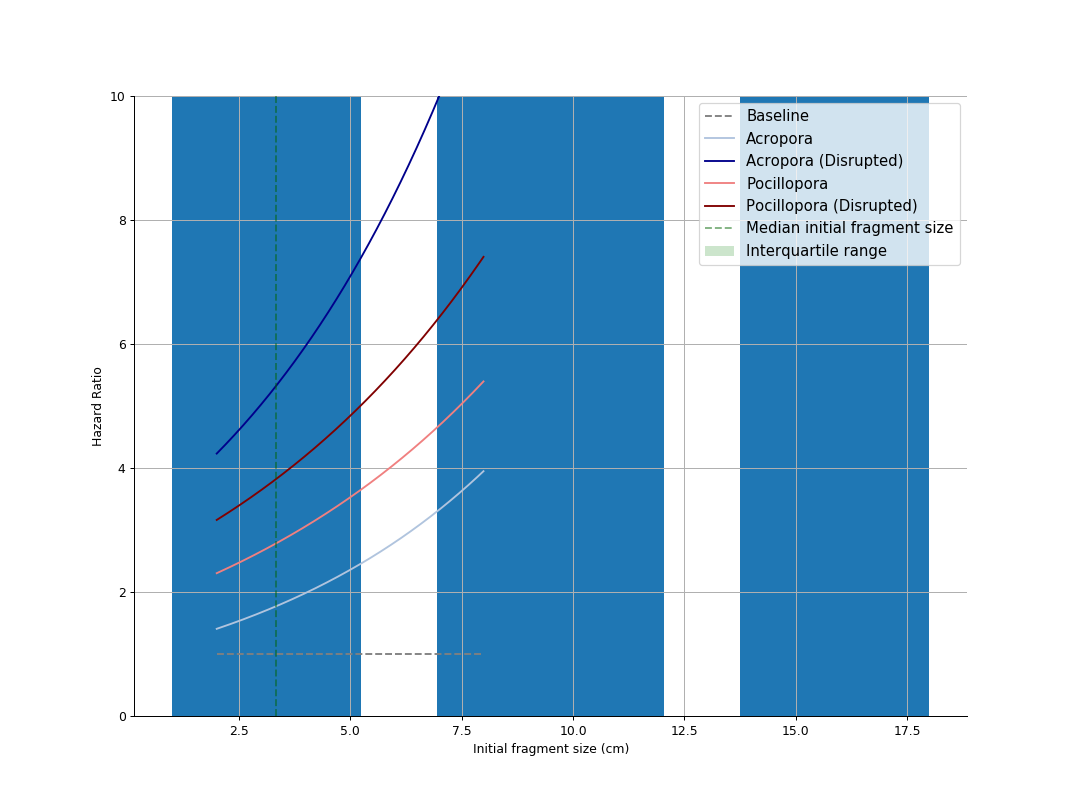

In [19]:
p_, dis_, pdis_, as_, ps_ = ctv.params_
s = np.arange(2, 8, 0.01)
s1, s3 = 3.3, 4.7

fig, ax = pyplot.subplots(figsize = [12,9])

ax.plot(s, pd.Series(1, index = s), '--', label = 'Baseline', color = 'gray')
ax.plot(s, np.exp(dis_*0) * np.exp(s*as_), label = 'Acropora', color = 'lightsteelblue')
ax.plot(s, np.exp(dis_*1) * np.exp(s*as_), label = 'Acropora (Disrupted)', color = 'darkblue')
ax.plot(s, np.exp(p_) * np.exp((pdis_+dis_)*0) * np.exp(s*ps_), label = 'Pocillopora', color = 'lightcoral')
ax.plot(s, np.exp(p_) * np.exp((pdis_+dis_)*1) * np.exp(s*ps_), label = 'Pocillopora (Disrupted)', color = 'maroon')
ax.axvline(x=3.332, linestyle='--', label='Median initial fragment size', color = 'darkgreen', alpha = 0.5)
ax.fill_between(s, 0, 10, where=(s > 2.858) & (s <= 3.945), facecolor='green', alpha=0.2, label = 'Interquartile range')
ax.legend(prop={'size': 12})
ax.set_ylim(0, 10)
ax.set(xlabel='Initial fragment size (cm)', ylabel='Hazard Ratio')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


In [31]:
ad = X[X['Disrupted'] & (X['Type'] == 'Acropora')]
a = X[(~X['Disrupted']) & (X['Type'] == 'Acropora')]
pd = X[X['Disrupted'] & (X['Type'] == 'Pocillopora')]
p = X[(~X['Disrupted']) & (X['Type'] == 'Pocillopora')]

fig, ax = pyplot.subplots(figsize=[12, 8])

kmf0 = KaplanMeierFitter()
kmf0.fit(ad['T'] / 30.437, event_observed=ad['E'], label = 'Disrupted Acropora')
kmf1 = KaplanMeierFitter()
kmf1.fit(a['T'] / 30.437, event_observed=a['E'], label = 'Acropora')
kmf2 = KaplanMeierFitter()
kmf2.fit(pd['T'] / 30.437, event_observed=pd['E'], label = 'Disrupted Pocillopora')
kmf3 = KaplanMeierFitter()
kmf3.fit(p['T'] / 30.437, event_observed=p['E'], label = 'Pocillopora')


kmf0.plot_survival_function(ax=ax, color = 'black', ci_alpha = 0.1)
kmf1.plot_survival_function(ax=ax, color = 'cornflowerblue', ci_alpha = 0.1)
kmf3.plot_survival_function(ax=ax, color = 'navy', ci_alpha = 0.1)
kmf2.plot_survival_function(ax=ax, color = 'lightcoral', ci_alpha = 0.1)
#kmf4.plot_survival_function(ax=ax, color = 'firebrick', ci_alpha = 0.1)

from lifelines.plotting import add_at_risk_counts
add_at_risk_counts(kmf0, ax=ax)

ax.set_ylim(bottom=0)
ax.set_xlabel('Timeline (months)')
ax.set_ylabel('Survival Rate')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(prop={'size': 12})

<IPython.core.display.Javascript object>

KeyError: 'T'

# Influence of fragment size

<IPython.core.display.Javascript object>


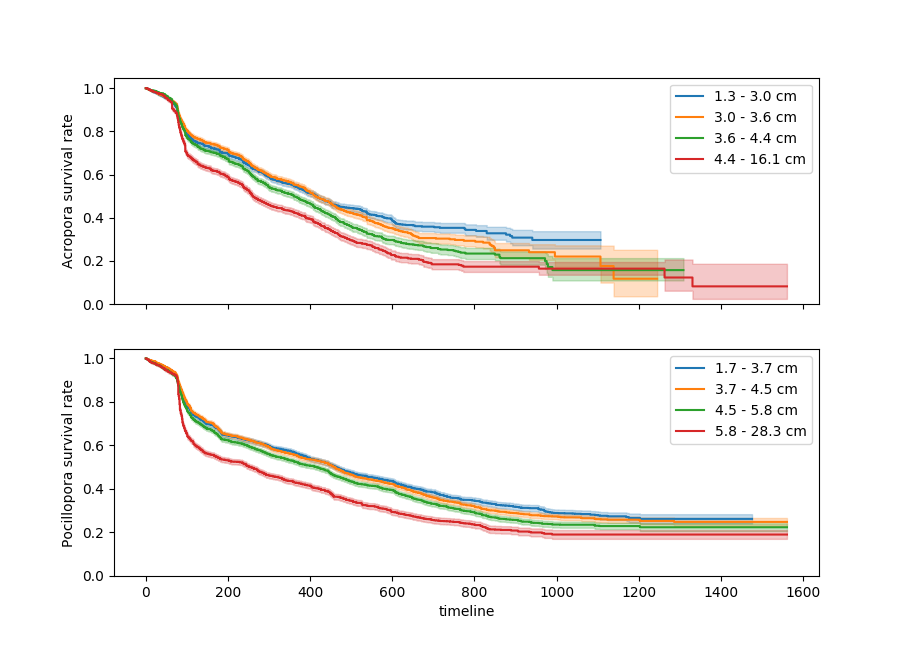

(0, 1.0414497692117175)

In [80]:
fig, axs = pyplot.subplots(2, sharex = True)

frags = fragdata['acro']
#frags = main[main['Type'] == 'Acropora']
q = 4
for i in range(q):
    q1, q2 = frags['Size'].quantile(i / q), frags['Size'].quantile((i+1) / q)
    databin = frags[(frags['Size'] > q1) & (frags['Size'] <= q2)]
    kmf = KaplanMeierFitter()
    kmf.fit(databin['T'], event_observed=databin['E'], label = '{:.1f} - {:.1f} cm'.format(0.3296*q1, 0.3296*q2))   
    kmf.plot_survival_function(ax = axs[0])

frags = fragdata['poc']
#frags = main[main['Type'] == 'Pocillopora']
for i in range(q):
    q1, q2 = frags['Size'].quantile(i / q), frags['Size'].quantile((i+1) / q)
    databin = frags[(frags['Size'] > q1) & (frags['Size'] <= q2)]
    kmf = KaplanMeierFitter()
    kmf.fit(databin['T'], event_observed=databin['E'], label = '{:.1f} - {:.1f} cm'.format(0.3296*q1, 0.3296*q2))
    kmf.plot_survival_function(ax = axs[1])

axs[0].set(ylabel='Acropora survival rate')
axs[0].legend()
axs[0].set_ylim(bottom=0)

axs[1].set(ylabel='Pocillopora survival rate')
axs[1].legend()
axs[1].set_ylim(bottom=0)

# Influence of geography (depth, shading)

<IPython.core.display.Javascript object>


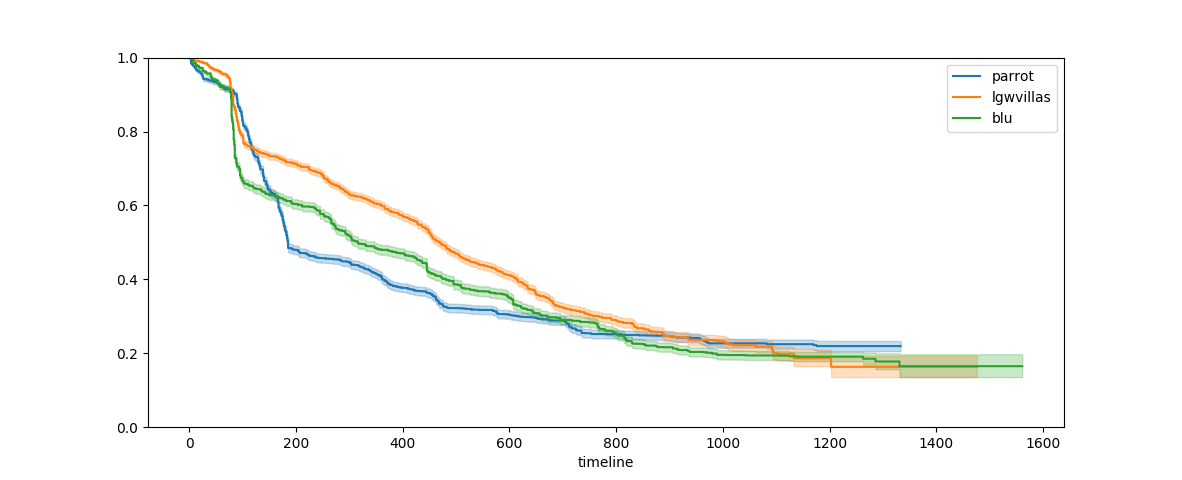

In [9]:
pyplot.ylim(bottom=0)
zones = ['parrot', 'lgwvillas', 'blu']

for z in zones:
    kmf = KaplanMeierFitter()
    kmf.fit(fragdata[z]['T'], event_observed=fragdata[z]['E'], label = z)
    kmf.plot_survival_function()

# Growth rates

In [10]:
livedf = get_growth_data()

<IPython.core.display.Javascript object>


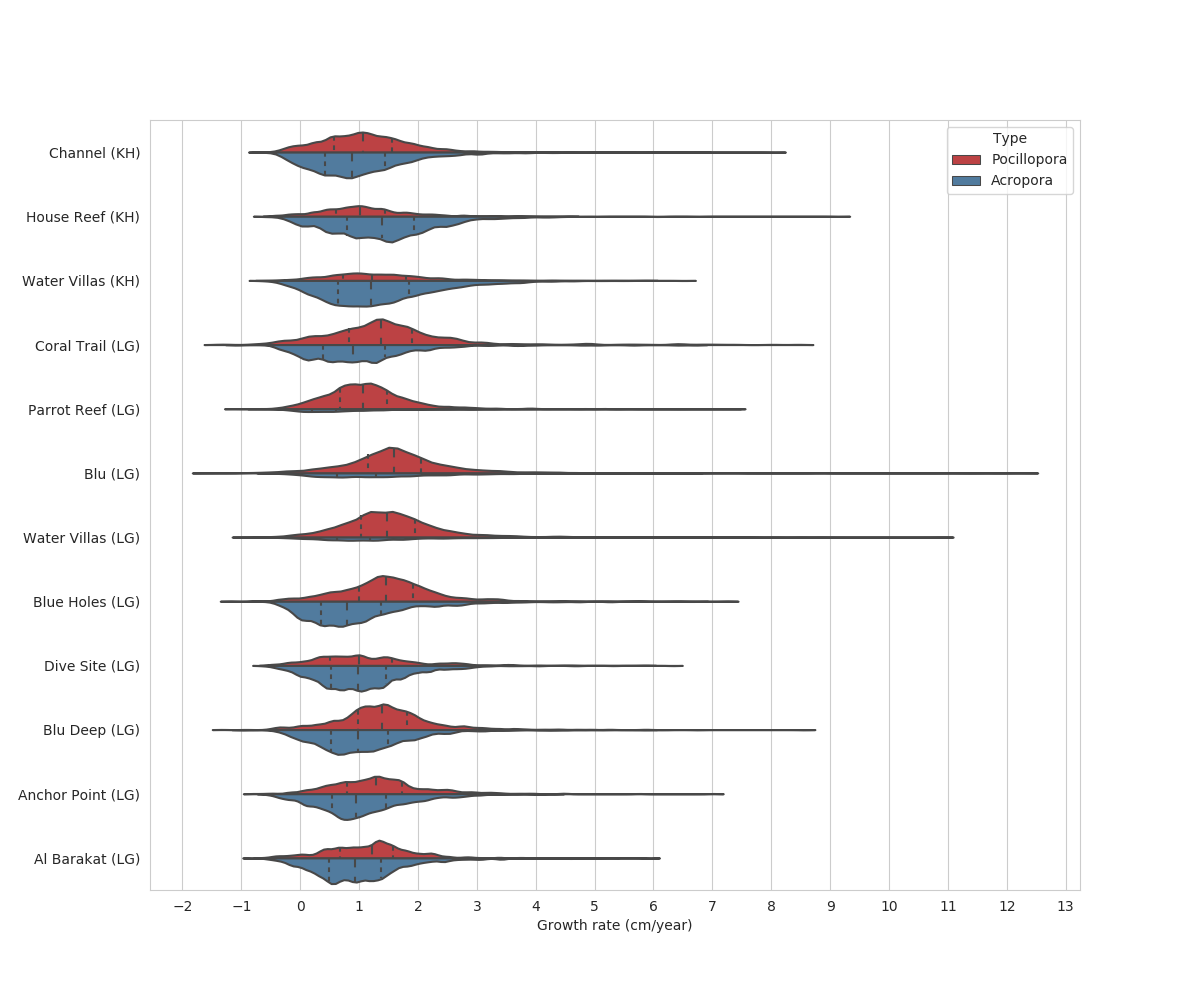

Text(0, 0.5, '')

In [20]:
import seaborn as sns
from matplotlib.ticker import MultipleLocator

fig, ax = pyplot.subplots(figsize=[12,10])

sns.set_style("whitegrid")
sns.violinplot(ax=ax, x="avgrowth", y="Zone", hue='Type', data=livedf, split = True, palette="Set1", inner="quartile",
               saturation = 0.6, bw = .1, scale = 'count')
ax.set_xlabel("Growth rate (cm/year)")
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.set_ylabel(None)

In [13]:
livedf.groupby(by=['Type'])['avgrowth'].quantile(0.75)

Type
Acropora       1.650996
Pocillopora    1.819822
Name: avgrowth, dtype: float64

# Total volume

In [9]:
live, dead, initial, fallen = get_volume_series()
acrodata = pd.DataFrame({'_Live Coral': live['Acropora'], '_Initial transplants': initial['Acropora'],
                     '_Dead Coral': -dead['Acropora'], '_Fallen Coral': -fallen['Acropora']})
pocdata = pd.DataFrame({'_Live Coral': live['Pocillopora'], '_Initial transplants': initial['Pocillopora'],
                     '_Dead Coral': -dead['Pocillopora'], '_Fallen Coral': -fallen['Pocillopora']})

acrodata.to_csv('acro_vol_data.csv')
pocdata.to_csv('poc_vol_data.csv')

<IPython.core.display.Javascript object>


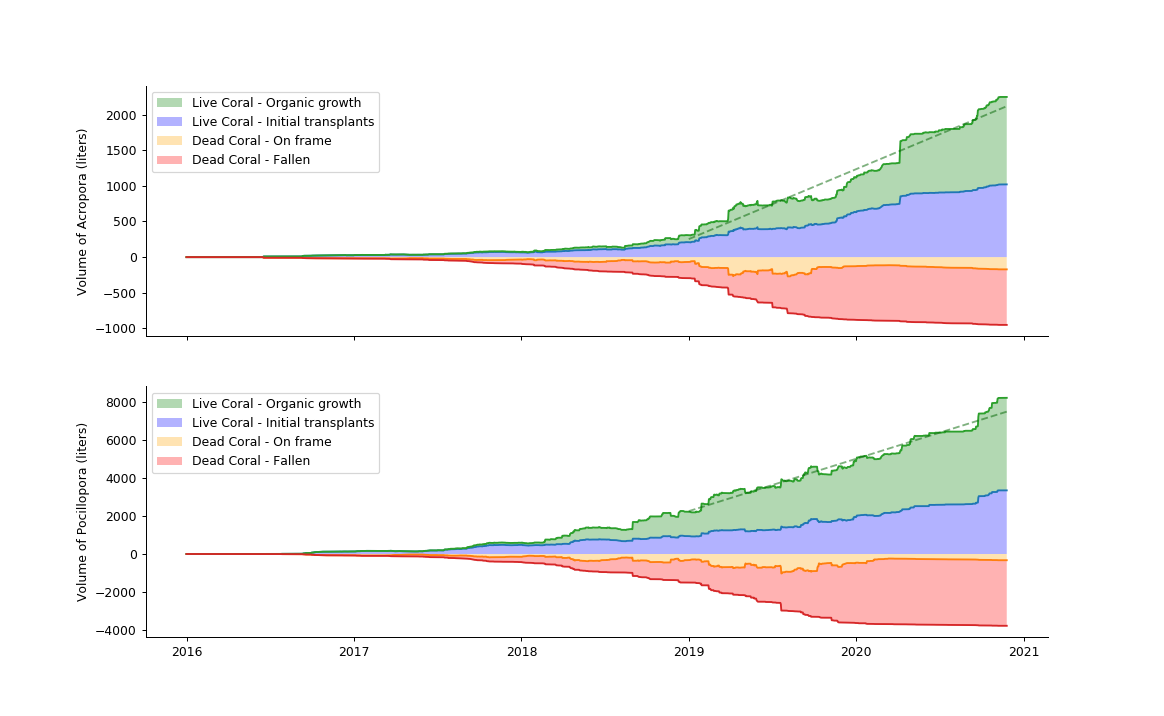

Acropora slope: 981 liters/year
Pocillopora slope: 2748 liters/year


In [31]:
acrodata = pd.read_csv('acro_vol_data.csv', index_col = 0, parse_dates = True)
pocdata = pd.read_csv('poc_vol_data.csv', index_col = 0, parse_dates = True)
pocdata['Date'] = pocdata.index
acrodata['Date'] = acrodata.index
d = pocdata['Date'].values

fig, axs = pyplot.subplots(2, sharex = True, figsize = [13, 8])

axs[0].plot_date(acrodata['Date'], acrodata['_Initial transplants'], '-')
axs[0].plot_date(acrodata['Date'], (acrodata['_Dead Coral'] - acrodata['_Fallen Coral']).rename('_Dead Coral on frame'), '-')
axs[0].plot_date(acrodata['Date'], acrodata['_Live Coral'], '-')
axs[0].plot_date(acrodata['Date'], acrodata['_Dead Coral'], '-')
axs[0].fill_between(d, acrodata['_Live Coral'], acrodata['_Initial transplants'], facecolor='green', alpha=0.3, interpolate=True, label = 'Live Coral - Organic growth')
axs[0].fill_between(d, 0, acrodata['_Initial transplants'], facecolor='blue', alpha=0.3, interpolate=True, label = 'Live Coral - Initial transplants')
axs[0].fill_between(d, acrodata['_Dead Coral'] - acrodata['_Fallen Coral'], 0, facecolor='orange', alpha=0.3, interpolate=True, label = 'Dead Coral - On frame')
axs[0].fill_between(d, acrodata['_Dead Coral'], acrodata['_Dead Coral'] - acrodata['_Fallen Coral'], facecolor='red', alpha=0.3, interpolate=True, label = 'Dead Coral - Fallen')
axs[0].set(ylabel='Volume of Acropora (liters)')
axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)
axs[0].legend(loc=2)

axs[1].plot_date(pocdata['Date'], pocdata['_Initial transplants'], '-')
axs[1].plot_date(pocdata['Date'], (pocdata['_Dead Coral'] - pocdata['_Fallen Coral']).rename('_Dead Coral on frame'), '-')
axs[1].plot_date(pocdata['Date'], pocdata['_Live Coral'], '-')
axs[1].plot_date(pocdata['Date'], pocdata['_Dead Coral'], '-')
axs[1].fill_between(d, pocdata['_Live Coral'], pocdata['_Initial transplants'], facecolor='green', alpha=0.3, interpolate=True, label = 'Live Coral - Organic growth')
axs[1].fill_between(d, 0, pocdata['_Initial transplants'], facecolor='blue', alpha=0.3, interpolate=True, label = 'Live Coral - Initial transplants')
axs[1].fill_between(d, pocdata['_Dead Coral'] - pocdata['_Fallen Coral'], 0, facecolor='orange', alpha=0.3, interpolate=True, label = 'Dead Coral - On frame')
axs[1].fill_between(d, pocdata['_Dead Coral'], pocdata['_Dead Coral'] - pocdata['_Fallen Coral'], facecolor='red', alpha=0.3, interpolate=True, label = 'Dead Coral - Fallen')
axs[1].set(ylabel='Volume of Pocillopora (liters)')
axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)
axs[1].legend(loc=2)

# Add trend lines:

from sklearn.linear_model import LinearRegression

df = pd.DataFrame()
df['a'] = acrodata.loc[acrodata.index.year >= 2019]['_Live Coral']
df['p'] = pocdata.loc[pocdata.index.year >= 2019]['_Live Coral']
df['Date'] = df.index
df['RelDate'] = (df['Date'].dt.date - date(year=2019, month=1, day=1)).dt.days

x, y_a, y_p = np.array(df['RelDate']).reshape(-1, 1), np.array(df['a']).reshape(-1, 1), np.array(df['p']).reshape(-1, 1)
model_a, model_p = LinearRegression().fit(x,y_a), LinearRegression().fit(x,y_p)
df['a_trend'] = model_a.intercept_[0] + model_a.coef_[0][0]*df['RelDate']
df['p_trend'] = model_p.intercept_[0] + model_p.coef_[0][0]*df['RelDate']
axs[0].plot_date(df['Date'].dt.date, df['a_trend'], '--', color = 'darkgreen', alpha = 0.5)
axs[1].plot_date(df['Date'].dt.date, df['p_trend'], '--', color = 'darkgreen', alpha = 0.5)

print('Acropora slope: {:.0f} liters/year'.format(model_a.coef_[0][0]*365.25))
print('Pocillopora slope: {:.0f} liters/year'.format(model_p.coef_[0][0]*365.25))

# Methods - Residuals

In [23]:
from scipy.stats import norm

df = pd.read_csv('SizeCheck.csv')
df['Len_res'] = df['mL'] - 0.3296 * df['cL']
df['Vol_res'] = df['mV'] - 0.1568*df['cV']

<IPython.core.display.Javascript object>


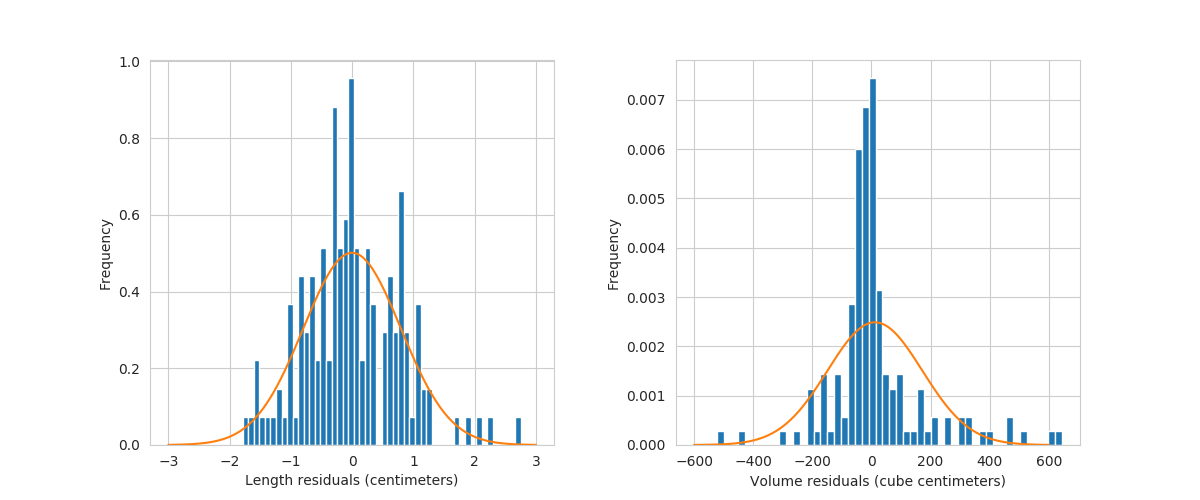

In [26]:
fig, axs = pyplot.subplots(1,2, figsize = [12, 5])

df.hist('Len_res', ax = axs[0], density = True, bins = 50)
x0 = np.arange(-3, 3, 0.001)
y0 = norm.pdf(x0,df['Len_res'].mean(),df['Len_res'].std())
axs[0].set(xlabel='Length residuals (centimeters)')
axs[0].set(ylabel='Frequency')
axs[0].set(title=None)
axs[0].plot(x0, y0)

df.hist('Vol_res', ax = axs[1], density = True, bins = 50)
x1 = np.arange(-600, 600, 0.1)
y1 = norm.pdf(x1,df['Vol_res'].mean(),df['Vol_res'].std())
axs[1].set(xlabel='Volume residuals (cube centimeters)')
axs[1].set(ylabel='Frequency')
axs[1].set(title=None)
axs[1].plot(x1, y1)